# Automatic loan verification

Author: Elijah Jacobs

Course Project, UC Irvine, Math 10, Spring 25

I would like to post my notebook on the course's website. Yes

# Introduction

In this project I will work on a dataset regarding loan dispersement and ideally make a model to classify a loan as able to be dispersed or not. I am focusing on this because as a student with loans, I would like to know how the whole process might be able to be modeled using regression and classification methods we learned in class. 

The dataset that I will be using was found on Kaggle, I will post the link under this paragraph. It includes many factors that may go into consideration for a loan and holds 45,000 instances each with 14 variables of interest.

https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

# Features:

__person_age:__  Age of the person in years

__person_gender:__ Gender of the person

__person_education:__ Highest education level

__person_income:__ Annual income in dollars

__person_emp_exp:__ Years of employment experience

__person_home_ownership:__ Home ownership status (e.g., rent, own, mortgage)	

__loan_amnt:__ Loan amount requested in dollars

__loan_intent:__ Purpose of the loan	

__loan_int_rate:__ Loan interest rate	

__loan_percent_income:__ Loan amount as a percentage of annual income

__cb_person_cred_hist_length:__ Length of credit history in years	

__credit_score:__ Credit score of the person	

__previous_loan_defaults_on_file:__ Indicator of previous loan defaults	

__loan_status:__ Loan approval status: 1 = approved; 0 = rejected	This is our target variable

In [21]:
# importing all the important libraries required
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lin
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now I will load the data set and drop any na values if there are any

In [2]:
df = pd.read_csv('loan_data.csv')
df.dropna(inplace=True)
df

person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
...           ...           ...              ...            ...   
44995        27.0          male        Associate        47971.0   
44996        37.0        female        Associate        65800.0   
44997        33.0          male        Associate        56942.0   
44998        29.0          male         Bachelor        33164.0   
44999        24.0          male      High School        51609.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0                  RENT    35000.0           PERSONAL   
1                   0                   OWN     1000.0          EDUCATION   
2                   3              MORTGAGE     5500.0            MEDICAL   
3                   0                  RENT    35000.0            MEDICAL   
4                   1                  RENT    35000.0            MEDICAL   
...               ...                   ...        ...                ...   
44995               6                  RENT    15000.0            MEDICAL   
44996              17                  RENT     9000.0    HOMEIMPROVEMENT   
44997               7                  RENT     2771.0  DEBTCONSOLIDATION   
44998               4                  RENT    12000.0          EDUCATION   
44999               1                  RENT     6665.0  DEBTCONSOLIDATION   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0              16.02                 0.49                         3.0   
1              11.14                 0.08                         2.0   
2              12.87                 0.44                         3.0   
3              15.23                 0.44                         2.0   
4              14.27                 0.53                         4.0   
...              ...                  ...                         ...   
44995          15.66                 0.31                         3.0   
44996          14.07                 0.14                        11.0   
44997          10.02                 0.05                        10.0   
44998          13.23                 0.36                         6.0   
44999          17.05                 0.13                         3.0   

       credit_score previous_loan_defaults_on_file  loan_status  
0               561                             No            1  
1               504                            Yes            0  
2               635                             No            1  
3               675                             No            1  
4               586                             No            1  
...             ...                            ...          ...  
44995           645                             No            1  
44996           621                             No            1  
44997           668                             No            1  
44998           604                             No            1  
44999           628                             No            1  

[45000 rows x 14 columns]

This what the distributions of the data look like

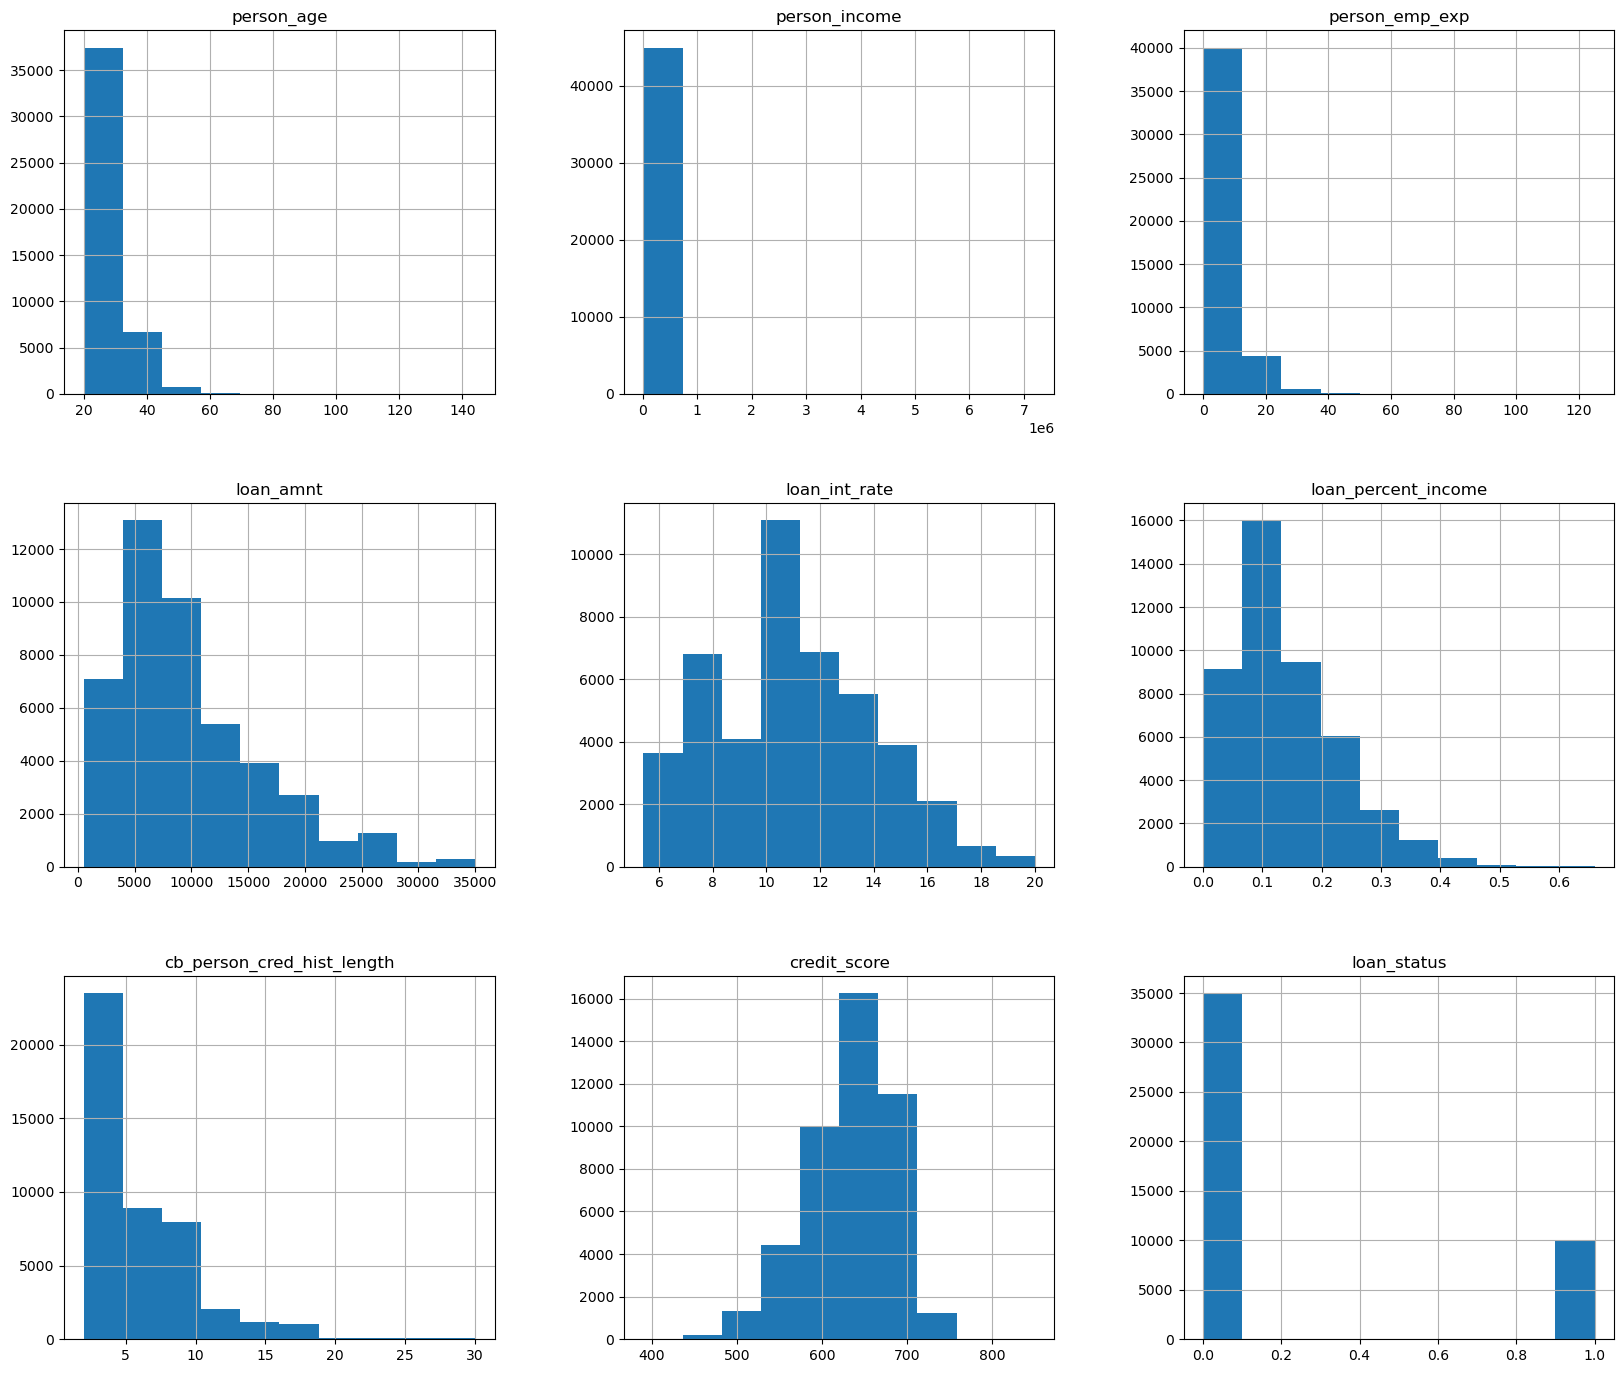

In [3]:
df.hist(figsize=(20,17))
plt.show()

the only histogram here that doesn't look neat is person_income, so I will graph it again separately so we have an idea of what it looks like.

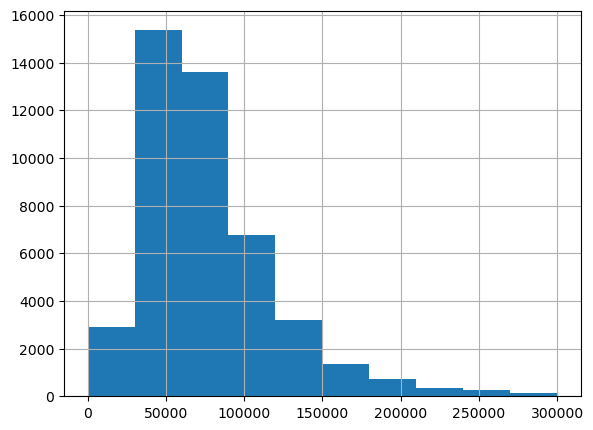

In [4]:
df['person_income'].hist(figsize=(20/3,20/4),range=(0,300000))
plt.show()

We can see that a lot of our data is roughly normally distributed, allowing us to standardize it as such later when we scale down some of our datav for modeling purposes.

Since previous loan defaults is only made up of yes's and no's I am going to change the data there so that yes = 1 and no = 0

I will do the same with gender with 1 as male and 0 as female

In [5]:
# makes it so if previous_loan_defaults_on_file is Yes or 1 or True then it will set it to be True/1 and everything else to False/0
df['previous_loan_defaults_on_file'] = ((df['previous_loan_defaults_on_file'] == 'Yes') | (df['previous_loan_defaults_on_file'] == 1))*1

# makes it so if person_gender is male or 1 or True then it will set it to be True/1 and everything else to False/0
df['person_gender'] = ((df['person_gender'] == 'male') | (df['person_gender'] == 1))*1

print(df['previous_loan_defaults_on_file'])
print(df['person_gender'])

0        0
1        1
2        0
3        0
4        0
        ..
44995    0
44996    0
44997    0
44998    0
44999    0
Name: previous_loan_defaults_on_file, Length: 45000, dtype: int32
0        0
1        0
2        0
3        0
4        1
        ..
44995    1
44996    0
44997    1
44998    1
44999    1
Name: person_gender, Length: 45000, dtype: int32


In order to use the categorical data I am going to use the one-hot-encoder method where we will have new features based on the classifications of things like gender and education, where each row will be either a 1 or a 0 in each of the new features depending on what classification they belong to.

code flows from https://www.geeksforgeeks.org/ml-one-hot-encoding/ 

In [6]:
catagories = ['person_education', 'person_home_ownership', 'loan_intent']

# make OneHotEncoder object
OHE = OneHotEncoder(sparse_output=False)

# apply object to our categorical data
newcata = OHE.fit_transform(df[catagories])

# add new features to our dataframe
clean_df = pd.concat([df, pd.DataFrame(newcata, columns=OHE.get_feature_names_out(catagories), index=df.index)], axis=1)

# drop original categories
clean_df.drop(columns=catagories, inplace=True)


clean_df

person_age  person_gender  person_income  person_emp_exp  loan_amnt  \
0            22.0              0        71948.0               0    35000.0   
1            21.0              0        12282.0               0     1000.0   
2            25.0              0        12438.0               3     5500.0   
3            23.0              0        79753.0               0    35000.0   
4            24.0              1        66135.0               1    35000.0   
...           ...            ...            ...             ...        ...   
44995        27.0              1        47971.0               6    15000.0   
44996        37.0              0        65800.0              17     9000.0   
44997        33.0              1        56942.0               7     2771.0   
44998        29.0              1        33164.0               4    12000.0   
44999        24.0              1        51609.0               1     6665.0   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0              16.02                 0.49                         3.0   
1              11.14                 0.08                         2.0   
2              12.87                 0.44                         3.0   
3              15.23                 0.44                         2.0   
4              14.27                 0.53                         4.0   
...              ...                  ...                         ...   
44995          15.66                 0.31                         3.0   
44996          14.07                 0.14                        11.0   
44997          10.02                 0.05                        10.0   
44998          13.23                 0.36                         6.0   
44999          17.05                 0.13                         3.0   

       credit_score  previous_loan_defaults_on_file  ...  \
0               561                               0  ...   
1               504                               1  ...   
2               635                               0  ...   
3               675                               0  ...   
4               586                               0  ...   
...             ...                             ...  ...   
44995           645                               0  ...   
44996           621                               0  ...   
44997           668                               0  ...   
44998           604                               0  ...   
44999           628                               0  ...   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
0                                 0.0                          0.0   
1                                 0.0                          0.0   
2                                 1.0                          0.0   
3                                 0.0                          0.0   
4                                 0.0                          0.0   
...                               ...                          ...   
44995                             0.0                          0.0   
44996                             0.0                          0.0   
44997                             0.0                          0.0   
44998                             0.0                          0.0   
44999                             0.0                          0.0   

       person_home_ownership_OWN  person_home_ownership_RENT  \
0                            0.0                         1.0   
1                            1.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         1.0   
4                            0.0                         1.0   
...                          ...                         ...   
44995                        0.0                         1.0   
44996                        0.0                         1.0   
44997                        0.0                       

Now that we have our data fixed up we can now get along with trying a classification algorithm.

# Classification algorithm

Before using any of the data, I am going to check for what features are colinear and remove them from consideration, however I will not be getting rid of any of the categorical data. First I will graph the scatter plots of all the data, and then I will check the linearity matrix to see what I should remove.

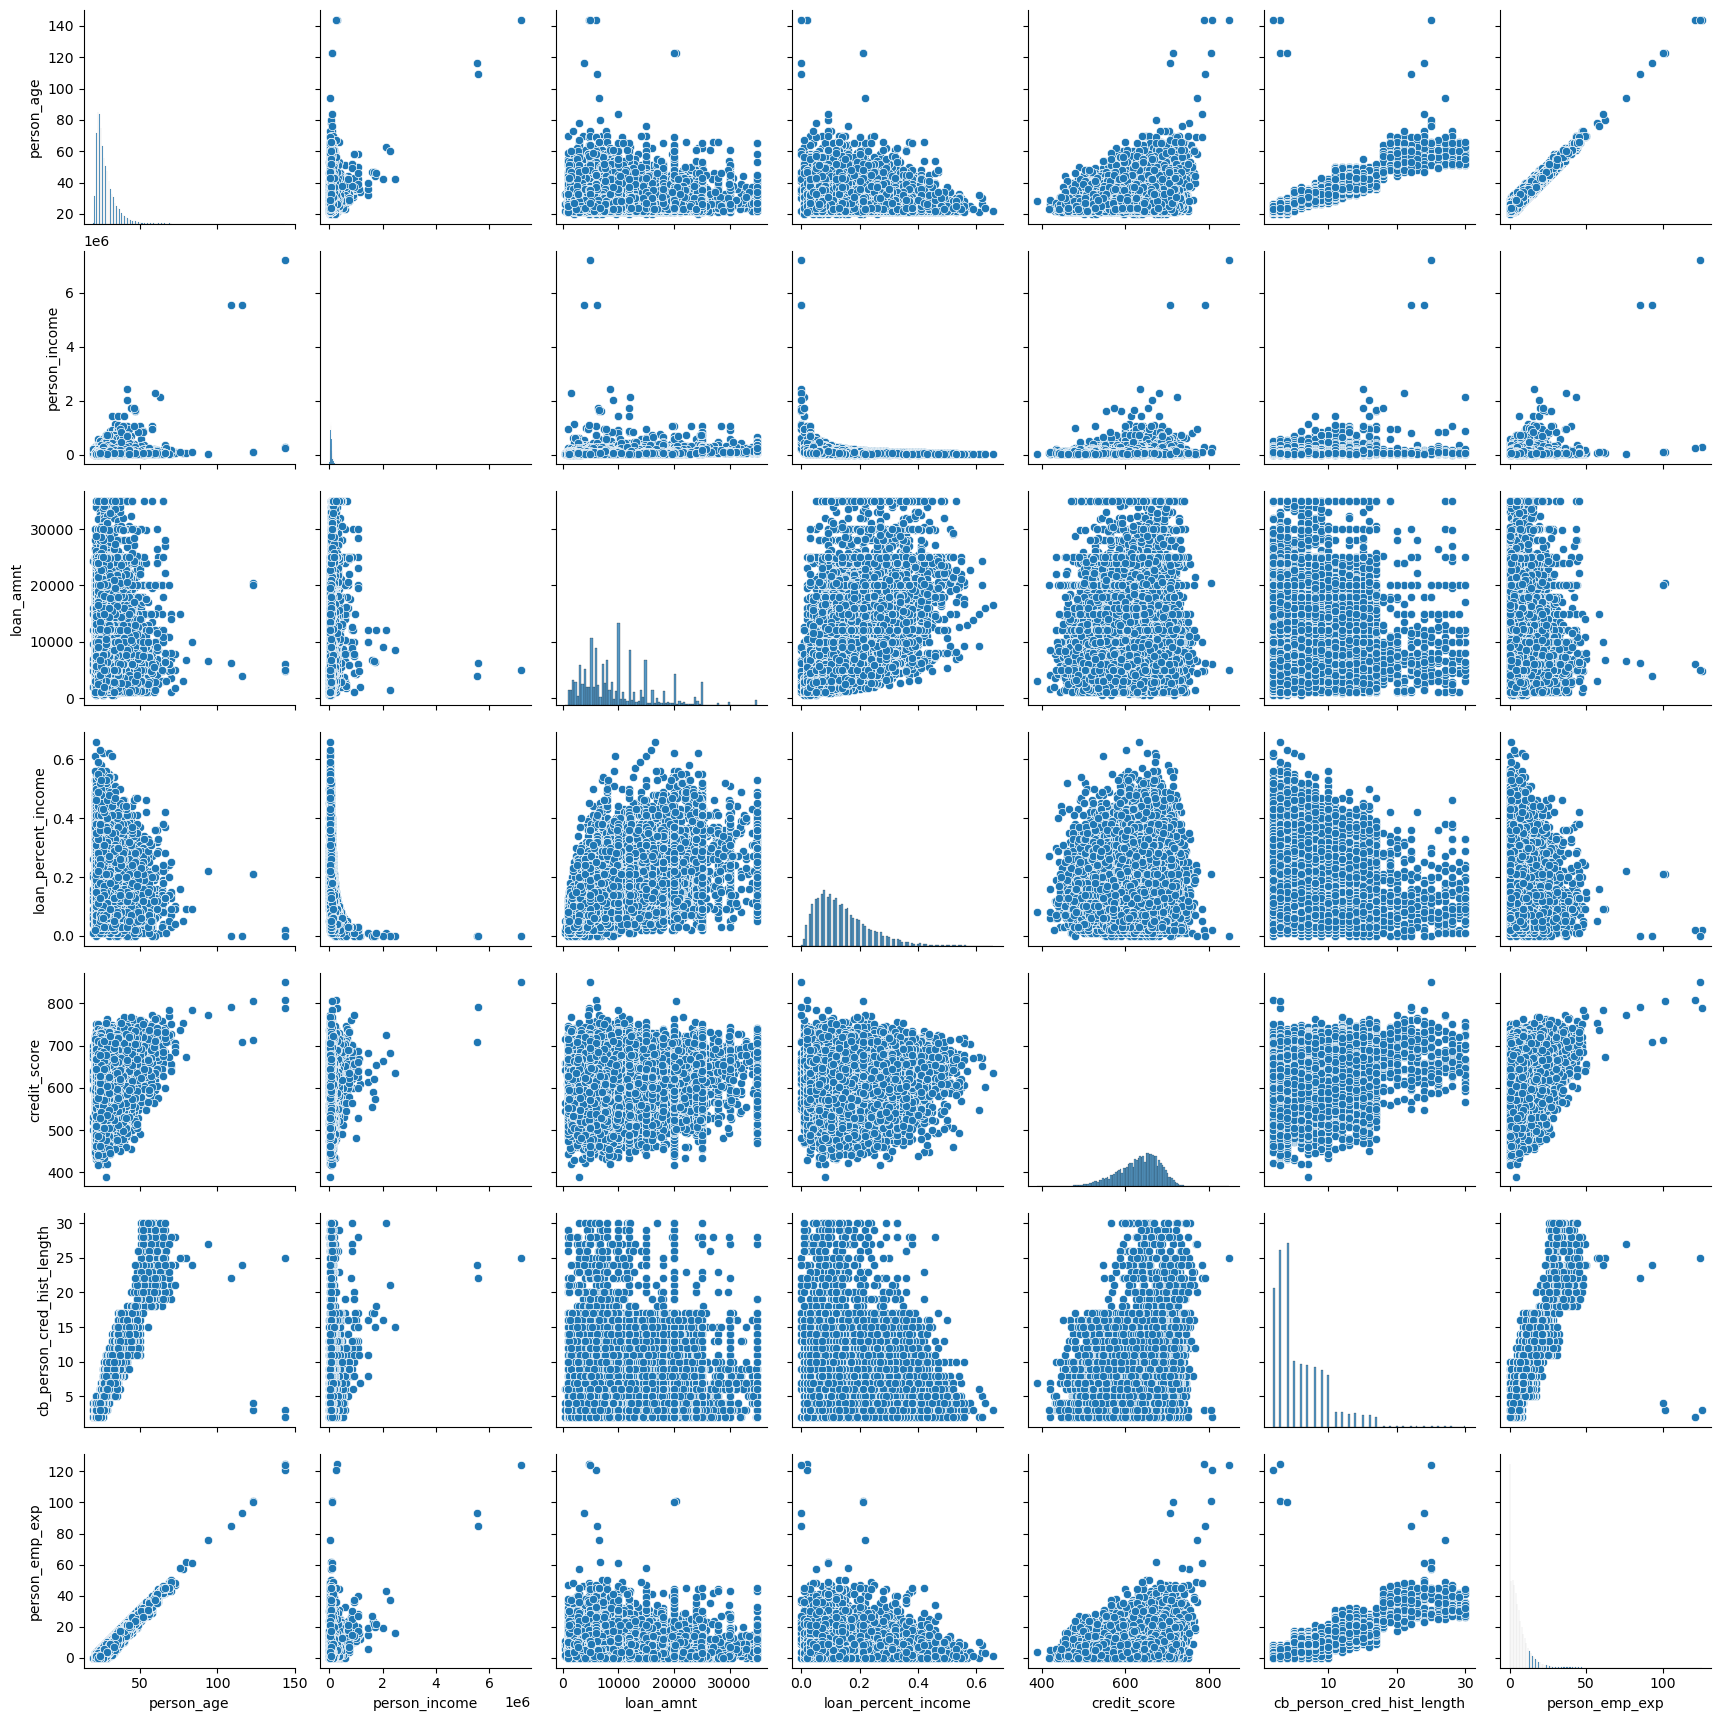

In [7]:
sns.pairplot(df[['person_age', 'person_income', 'loan_amnt', 'loan_percent_income', 'credit_score','cb_person_cred_hist_length','person_emp_exp']], diag_kind='hist')

It appears that things like credit history, age, and employment time all correlate pretty highly. We will confirm this notion with a correlation matrix.

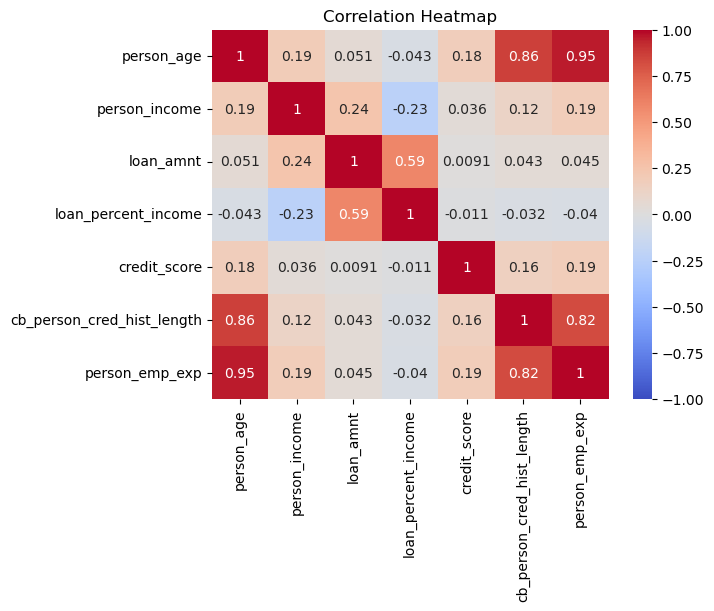

In [8]:
correlation_matrix = clean_df[['person_age', 'person_income', 'loan_amnt', 'loan_percent_income', 'credit_score','cb_person_cred_hist_length','person_emp_exp']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

We are right, and due to the high colinearity between credit history, employment history, and age, I will keep the person's age and drop the other two columns from the data.

By the way, there is an abundance of data meaning there is no need to use cross validation or folds, I will do a 60-40 split of the data. I will also be scaling the data with regards to a normal distribution so it is easier to train later models.

In [9]:
# defines what columns are to be changed
fixed_df = clean_df.drop(columns=['person_emp_exp', 'cb_person_cred_hist_length'])
columns = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'credit_score']
# changes columns
for column in columns:
    fixed_df[column] =(fixed_df[column] - fixed_df[column].mean() ) / fixed_df[column].std()

# split data  into features and targets
df_features = fixed_df.drop(columns='loan_status')
df_target = fixed_df['loan_status']

#split features and targets into testing and training sets
train_features, test_features, train_target, test_target = train_test_split(df_features, df_target, test_size=.4) 

I will be trying two different models to see what works best, for starters however I am interested in how well logistic regression does with classifying our data.

## Logistic

In [10]:
# trains logistic model

log = lin.LogisticRegression(max_iter=10000)
log.fit(train_features, train_target)

LogisticRegression(max_iter=10000)

We will now display the accuracy on the testing and training sets

In [11]:
#tests logistic model, showing it's accuracy
print(f'train acc: {log.score(train_features, train_target)}')
print(f'test acc: {log.score(test_features, test_target)}')

train acc: 0.8952222222222223
test acc: 0.8964444444444445


Both values exceeded my expectations. I thought the model might not be able to fit to such a large dataset, I am happy my worries were missplaced.

For now I will continue and show the confusion matrix to get a better sense of how well the data is being modeled.

I figured out how to do percentages for the confusion matrix with the website given here:
https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea 

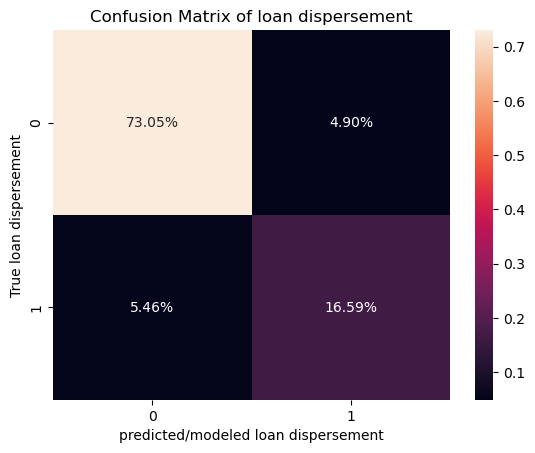

In [12]:
# creates confusion matrix
con = confusion_matrix(test_target, log.predict(test_features))

#creates heatmap of confusion matrix
sns.heatmap(con/np.sum(con), annot=True, xticklabels=[0,1], yticklabels=[0,1], fmt='.2%')
plt.xlabel('predicted/modeled loan dispersement')
plt.ylabel('True loan dispersement')
plt.title('Confusion Matrix of loan dispersement')
plt.show()

Here a 1 means that the loan was dispersed and a 0 means that it was not dispersed. I am quite happy with how logistic regression did at modeling the given data as the accuracy was pretty close to 90% and the false negatives and false positives are pretty equally distributed meaning that the model is giving out a normal amount of loans rather than giving too much or too little. Due to how accurate the model runs on the testing data, there is likely no over-fitting in the model.

# Neural Network

Now that I have tried logistic regression I am interested in how well a neural network will handle the data.

We will use the same split as the previous model.

Credit to both the math10 course website by Professor Zhang, Chad, and the Pytorch website for this next bit

https://rayzhangzirui.github.io/math10sp25/notes/intro_nn.html

https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html 

Epoch 1, loss: 0.5932, training accuracy: 77.66%    test accuracy: 77.95%
Epoch 2, loss: 0.5932, training accuracy: 77.66%    test accuracy: 77.95%
Epoch 3, loss: 0.5932, training accuracy: 77.66%    test accuracy: 77.95%
Epoch 4, loss: 0.5911, training accuracy: 77.66%    test accuracy: 77.95%
Epoch 5, loss: 0.4063, training accuracy: 89.39%    test accuracy: 89.30%
Epoch 6, loss: 0.4017, training accuracy: 89.44%    test accuracy: 89.50%
Epoch 7, loss: 0.4042, training accuracy: 89.37%    test accuracy: 89.53%
Epoch 8, loss: 0.4057, training accuracy: 89.44%    test accuracy: 89.58%
Epoch 9, loss: 0.4069, training accuracy: 89.55%    test accuracy: 89.60%
Epoch 10, loss: 0.4079, training accuracy: 89.61%    test accuracy: 89.70%
Epoch 11, loss: 0.4083, training accuracy: 89.69%    test accuracy: 89.78%
Epoch 12, loss: 0.4082, training accuracy: 89.74%    test accuracy: 89.89%
Epoch 13, loss: 0.4075, training accuracy: 89.84%    test accuracy: 89.98%
Epoch 14, loss: 0.4067, training a

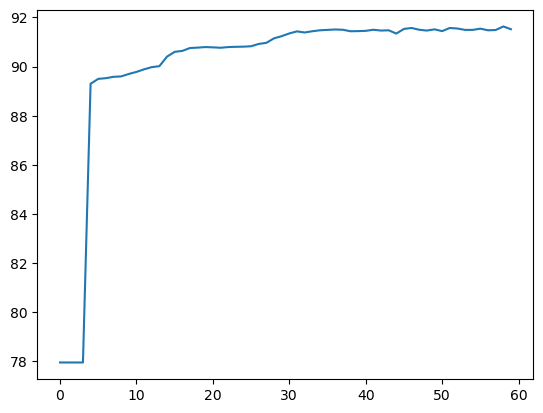

In [22]:
# defining a dataset class to reformat data
class MyDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

# making data sets
train_ds = MyDataset(train_features.astype('float32').values, train_target.values)
test_ds = MyDataset(test_features.astype('float32').values, test_target.values)

batch_size = 100

# Creating dataloaders
train_dataloader = DataLoader(train_ds, batch_size=batch_size)
test_dataloader = DataLoader(test_ds, batch_size=batch_size)

# defining model
layer_size = 20

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(23, layer_size),
            nn.Sigmoid(),
            nn.Linear(layer_size, layer_size),
            nn.Sigmoid(),
            nn.Linear(layer_size, layer_size),
            nn.Sigmoid(),
            nn.Linear(layer_size, layer_size),
            nn.Sigmoid(),
            nn.Linear(layer_size, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        prob = nn.functional.softmax(logits, dim=1)
        return prob

model = NeuralNet()

# making Loss and Optimizer
bceloss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.005)



# Computes accuracy
def evaluate(loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for features, target in loader:
            features, target = features, target
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

# Run training through the data 100 times and store values of testing accuracy in a list
n_epoch = 60
acc_list = []

for epoch in range(n_epoch): 
    model.train()
    for features, target in train_dataloader:
        features, target = features, target
        outputs = model(features)
        loss = bceloss(outputs, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
# gives accuracy of each epoch of the training and testing data
    accuracy = evaluate(test_dataloader)
    acc_list.append(accuracy)
    accuracyT = evaluate(train_dataloader)
    print(f'Epoch {epoch+1}, loss: {loss.item():.4f}, training accuracy: {accuracyT:.2f}%    test accuracy: {accuracy:.2f}%')

# Evaluate the final accuracy on testing set
final_accuracy = evaluate(test_dataloader)
print(f'Test Accuracy: {final_accuracy:.2f}%')

plt.plot(acc_list)


I initially ran this having not scaled the data to be standardized and was very confused when I was getting consistent values of 77.73% for the accuracy of the model. Now however, I have fixed that and am consistently getting better accuracy than the logistical model at above 91%. Due to how close the testing and training accuracy are to each other there is likely very little over-fitting meaning that are model isn't too complex, which would've caused too much variance in our data due to the bias-variance tradeoff.

From the graph we can see that the model experience's a large initial increase in accuracy, then it very slowly increases up to about 91%, then the accuracy levels out after about 15-20 epochs.

Regardless, both models appear to accurately depict the loan dispersement data.

# Conclusion

Modeling the dispersement of loans is done effectively through the use of Logistic regression, however the use of neural networks appears to lead to slight improvements in accuracy when compared to the logistical model.

This is all to say that it is possible to make a machine to predict whether or not some was or was not approved for a loan. This can lead to automation in banking, ultimately cutting costs that would normally be paid to human analysts, allowing them to focus more on the overview of these models and perhaps more important issues in banking that they would not have been able to weigh in on initially.



I'd say these models are quite comforting as someone who might need loans later their life. As with a relatively linear relationship, it can be expected that one would need to meet certain specific criteria in order to get a loan, the process of getting one isn't based completely on luck.